In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.spatial import ConvexHull

In [2]:
def Normalize(matrix):
    return matrix / np.linalg.norm(matrix)


In [3]:
class ViewFrustum:
    def __init__(self, data_path=None, pos=None, look_at=None, up=None, vfov=None, far=None, near=None):
        if(data_path is not None):
            self.Init_from_Path(data_path)
        elif(pos is not None and look_at is not None and up is not None and vfov is not None and far is not None and near is not None):
            self.Init_from_Data(pos, look_at, up, vfov, far, near)
        else:
            self.pos     = np.full(3, dtype=np.float64, fill_value=0.0)
            self.look_at = np.full(3, dtype=np.float64, fill_value=0.0)
            self.up      = np.full(3, dtype=np.float64, fill_value=0.0)
            self.vfov    = np.full(4, dtype=np.float64, fill_value=0.0)
            self.far     = 1000.0
            self.near    = 1.0
            self.valid   = False



    def Init_from_Path(self, data_path):
        self.pos     = np.full(3, dtype=np.float64, fill_value=0.0)
        with open(data_path, "rb") as f:
            self.look_at = np.fromfile(f, dtype=np.float32, count=3)
            self.look_at = self.look_at.astype(np.float64)
            self.up      = np.fromfile(f, dtype=np.float32, count=3)
            self.up      =      self.up.astype(np.float64)
            self.vfov    = np.fromfile(f, dtype=np.float32, count=4)
            self.vfov    =    self.vfov.astype(np.float64)
        # for i in range(3):
        #     self.vfov[i] = np.deg2rad(self.vfov[i])
        self.far     = 1000.0
        self.near    = 1
        self.aspect  = np.tan(self.vfov[1]) / np.tan(self.vfov[2])
        self.valid = True


    def Init_from_Data(self, pos, look_at, up, vfov, far, near):
        self.pos     = pos
        self.look_at = look_at
        self.up      = up
        self.vfov    = vfov
        self.far     = far
        self.near    = near
        self.aspect  = np.tan(self.vfov[1]) / np.tan(self.vfov[2])
        self.valid = True


    def Save_To_File(self, path):
        with open(path, "wb") as f:
            self.look_at.astype(np.float32).tofile(f)
            self.up.astype(np.float32).tofile(f)
            self.vfov.astype(np.float32).tofile(f)
        return


    def Valid(self):
        if not self.valid:
            print("Not a valid frustum.")
            raise Warning("Not a valid frustum.")
        return
    


    def CalcCameraAxis(self):
        self.Valid()
        self.Zaxis = (self.pos - self.look_at)          # F vector
        self.Zaxis = Normalize(self.Zaxis)              
        self.Xaxis = np.cross(self.up, self.Zaxis)      # R vector
        self.Xaxis = Normalize(self.Xaxis)
        self.Yaxis = np.cross(self.Zaxis, self.Xaxis)   # T vector
        self.Yaxis = Normalize(self.Yaxis)
        return
    


    def CalcViewMat(self):
        self.Valid()
        try:
            self.Xaxis
        except:
            self.CalcCameraAxis()

        self.view_matrix = np.full((4, 4), dtype = np.float64, fill_value=0.0)
        self.view_matrix[0][0] = self.Xaxis[0]
        self.view_matrix[0][1] = self.Xaxis[1]
        self.view_matrix[0][2] = self.Xaxis[2]
        self.view_matrix[0][3] = -np.dot(self.Xaxis, self.pos)
        self.view_matrix[1][0] = self.Yaxis[0]
        self.view_matrix[1][1] = self.Yaxis[1]
        self.view_matrix[1][2] = self.Yaxis[2]
        self.view_matrix[1][3] = -np.dot(self.Yaxis, self.pos)
        self.view_matrix[2][0] = self.Zaxis[0]
        self.view_matrix[2][1] = self.Zaxis[1]
        self.view_matrix[2][2] = self.Zaxis[2]
        self.view_matrix[2][3] = -np.dot(self.Zaxis, self.pos)
        self.view_matrix[3][3] = 1.0
        return
    
    


    def CalcProjectionMat(self):
        self.Valid()
        
        self.projection_matrix = np.full((4, 4), dtype = np.float64, fill_value=0.0)
        # aspect = 1.0
        f = 1.0 / np.tan(self.vfov[2])
        self.projection_matrix[0][0] = f / self.aspect;
        self.projection_matrix[1][1] = f;
        self.projection_matrix[2][2] = (self.far + self.near) / (self.near - self.far);
        self.projection_matrix[3][2] = -1.0;
        self.projection_matrix[2][3] = -2.0 * self.far * self.near / (self.near - self.far);
        return
    
    
        
    def CalcFrustumCorners(self):
        self.Valid()
        try:
            self.Xaxis
        except:
            self.CalcCameraAxis()

        self.far_corners  = np.full((4, 3), dtype = np.float64, fill_value=0.0)
        self.near_corners = np.full((4, 3), dtype = np.float64, fill_value=0.0)
        # near plane
        self.near_corners[0] = self.pos - self.Zaxis * self.near + self.Yaxis * self.near * np.tan(self.vfov[2]) - self.Xaxis * self.near * np.tan(self.vfov[1])
        self.near_corners[1] = self.pos - self.Zaxis * self.near + self.Yaxis * self.near * np.tan(self.vfov[2]) + self.Xaxis * self.near * np.tan(self.vfov[1])
        self.near_corners[2] = self.pos - self.Zaxis * self.near - self.Yaxis * self.near * np.tan(self.vfov[2]) + self.Xaxis * self.near * np.tan(self.vfov[1])
        self.near_corners[3] = self.pos - self.Zaxis * self.near - self.Yaxis * self.near * np.tan(self.vfov[2]) - self.Xaxis * self.near * np.tan(self.vfov[1])
        # far plane
        self.far_corners[0] = self.pos - self.Zaxis * self.far + self.Yaxis * self.far * np.tan(self.vfov[2]) - self.Xaxis * self.far * np.tan(self.vfov[1])
        self.far_corners[1] = self.pos - self.Zaxis * self.far + self.Yaxis * self.far * np.tan(self.vfov[2]) + self.Xaxis * self.far * np.tan(self.vfov[1])
        self.far_corners[2] = self.pos - self.Zaxis * self.far - self.Yaxis * self.far * np.tan(self.vfov[2]) + self.Xaxis * self.far * np.tan(self.vfov[1])
        self.far_corners[3] = self.pos - self.Zaxis * self.far - self.Yaxis * self.far * np.tan(self.vfov[2]) - self.Xaxis * self.far * np.tan(self.vfov[1])
        return

In [4]:
def TransformPointToCameraSpace(point, Frustum):
    # transform point to camera space
    points = np.append(point, 1.0)
    points = np.dot(Frustum.view_matrix, points)
    return points


def ProjectPointToFrustumPlane(point, Frustum):
    # project point to near plane
    # print(point)
    points = np.append(point, 1.0)
    points = np.dot(Frustum.view_matrix, points)
    # print(points)
    points = np.dot(Frustum.projection_matrix, points)
    # print(points)
    points = points / points[3]
    # print(points)
    return points

In [5]:
def Build2DCoordinateSys(points):
    # Calculate the normal of the plane
    normal = np.cross(points[1] - points[0], points[2] - points[0])
    # Use the first point as the centroid
    centroid = points[0]
    # Exclude the first point when calculating the covariance matrix
    covariance_matrix = np.cov(points[1:], rowvar=False)
    # Calculate the eigenvalues and eigenvectors
    eigenvalues, eigenvectors = np.linalg.eig(covariance_matrix)
    # Sort the eigenvectors by eigenvalues
    idx = eigenvalues.argsort()[::-1]
    eigenvalues = eigenvalues[idx]
    eigenvectors = eigenvectors[:,idx]
    # Calculate the 2D coordinate system
    x_axis = eigenvectors[:,0]
    y_axis = eigenvectors[:,1]
    return centroid, x_axis, y_axis, normal


def Build2DCoordinateSysFromOnePointAndNormal(point, normal):
    # Normalize the normal vector to make it a unit vector
    unit_normal = Normalize(normal)
    
    # Find a vector that is not aligned with the normal vector
    if (unit_normal[0] == 0 and unit_normal[1] == 0):
        # The normal vector is aligned with the z-axis
        not_aligned_vector = np.array([1, 0, 0])  # Use x-axis as the not aligned vector
    else:
        # Use z-axis as the not aligned vector if the normal vector is not aligned with z-axis
        not_aligned_vector = np.array([0, 0, 1])
    
    # First axis in the plane
    x_axis = np.cross(unit_normal, not_aligned_vector)
    x_axis = Normalize(x_axis)  # Normalize the axis
    
    # Second axis in the plane, orthogonal to both the normal and first_axis
    y_axis = np.cross(unit_normal, x_axis)
    y_axis = Normalize(y_axis)  # Normalize the axis
    
    # The point is used as the origin of the new coordinate system
    centroid = np.array(point)
    
    # Return the origin and basis vectors of the new coordinate system
    return centroid, x_axis, y_axis, unit_normal


def TransformPointsTo2DCoordinateSys(points, centroid, x_axis, y_axis):
    points = points - centroid
    points = np.dot(points, np.array([x_axis, y_axis]).T)
    return points


def TransformPointsFrom2DCoordinateSys(points, centroid, x_axis, y_axis):
    points = np.dot(points, np.array([x_axis, y_axis]))
    points = points + centroid
    return points


def TransformVectorFrom2DCoordinateSys(vector, x_axis, y_axis):
    return vector[0] * x_axis + vector[1] * y_axis


def FindIntersectionsBetweenPlaneAndFrustum(Frustum, plane_normal, plane_point):
    # Find the intersection points between the plane and the frustum
    intersections = np.full((4, 3), dtype = np.float64, fill_value=0.0)
    result_status = True
    exception_msg = []
    for i in range(4):
        intersection, result = FindIntersectionBetweenLineAndPlane(Frustum.pos, Frustum.near_corners[i] - Frustum.pos, plane_normal, plane_point)
        intersections[i] = intersection
        if not result:
            result_status = False
            exception_msg.append(f'The intersection point {intersection} for the {i}th conner is behind the line point {Frustum.pos}')

    return intersections, result_status, exception_msg


def FindIntersectionBetweenLineAndPlane(line_point, line_direction, plane_normal, plane_point):
    # Find the intersection point between the line and the plane
    t = np.dot(plane_normal, plane_point - line_point) / np.dot(plane_normal, line_direction)
    intersection = line_point + t * line_direction
    # Check if the intersection point is 'behind' the line point
    if np.dot(line_direction, intersection - line_point) < 0:
        return intersection, False
    return intersection, True


def PorjectVectorAlphaToVectorBeta(alpha, beta):
    # Project vector alpha to vector beta
    return np.dot(alpha, beta) / np.dot(beta, beta) * beta


def VectorLengthInDirection(vector, direction):
    direction_norm = np.linalg.norm(direction)
    if direction_norm == 0:
        raise ValueError("Direction vector cannot be zero.")
    length = np.dot(vector, direction) / direction_norm
    return abs(length)

In [6]:
def DrawPointsOnPlane(points):
    plt.scatter(points[:,0], points[:,1])
    plt.show()
    return

def DrawPointsOnPlaneWithSeries(points):
    fig = plt.figure()
    ax = fig.add_subplot(111)
    ax.scatter(points[:,0], points[:,1])
    for i in range(len(points)):
        ax.text(points[i,0], points[i,1], '%s' % (str(i)), size=20, zorder=1, color='k')
    plt.show()
    return


def DrawPointsIn3DWithCentroid(points):
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    ax.scatter(points[:,0], points[:,1], points[:,2])
    for i in range(len(points)):
        ax.text(points[i,0], points[i,1], points[i,2], '%s' % (str(i)), size=20, zorder=1, color='k')
    ax.scatter(0, 0, 0, c='r', marker='o')
    plt.show()
    return

def DrawPointsIn3DWithCentroidAndAxises(points):
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    ax.scatter(points[:,0], points[:,1], points[:,2])
    for i in range(len(points)):
        ax.text(points[i,0], points[i,1], points[i,2], '%s' % (str(i)), size=20, zorder=1, color='k')
    ax.scatter(0, 0, 0, c='r', marker='o')
    ax.quiver(0, 0, 0, 1, 0, 0, color='r')
    ax.quiver(0, 0, 0, 0, 1, 0, color='g')
    ax.quiver(0, 0, 0, 0, 0, 1, color='b')
    plt.show()
    return

def DrawPlaneIn3D(plane_normal, plane_point):
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    x = np.linspace(-10, 10, 10)
    y = np.linspace(-10, 10, 10)
    x, y = np.meshgrid(x, y)
    z = (-plane_normal[0] * x - plane_normal[1] * y - np.dot(plane_normal, plane_point)) * 1.0 / plane_normal[2]
    ax.plot_surface(x, y, z, alpha=0.5)
    plt.show()
    return

def DrawOneQuQuadrilateralOnPlane(points, ax, color='r'):
    # Draw one quadrilateral on the plane
    for i in range(4):
        ax.plot([points[i][0], points[(i+1)%4][0]], [points[i][1], points[(i+1)%4][1]], color=color)
    return

def DrawQuadrilateralsOnPlane(quadrilaterals):
    # Draw the quadrilaterals with different color on the plane, each quadrilateral is represented by 4 points
    fig = plt.figure()
    ax = fig.add_subplot(111)
    color = ['r', 'g', 'b', 'y']
    for i in range(len(quadrilaterals)):
        DrawOneQuQuadrilateralOnPlane(quadrilaterals[i], ax, color=color[i])
        
    plt.show()

In [7]:
def are_points_in_same_plane(points):
    # Extract the first three points to define the plane
    point1 = points[0]
    point2 = points[1]
    point3 = points[2]
    
    # Calculate vectors representing two edges of the triangle formed by the first three points
    vector1 = point2 - point1
    vector2 = point3 - point1
    
    # Calculate the cross product of the two vectors
    cross_product = np.cross(vector1, vector2)
    
    # Iterate over the remaining points and check if they lie on the same plane
    for point in points[3:]:
        # Calculate the vector from the first point to the current point
        vector = point - point1
        
        # Calculate the dot product of the vector and the cross product
        dot_product = np.dot(vector, cross_product)
        
        # If the dot product is not close to zero, points are not in the same plane
        if not np.isclose(dot_product, 0):
            return False, dot_product, point
    
    return True

In [8]:
def Find_Best_Circumscribed_Rectangle_For_A_Convex_Hull(mid_point, hull_points, aspect):
    # Iteration parameters
    screen_wide_edge_direction = np.array([1, 0])
    rotate_step = 0.0001
    rotation_matrix = np.array([[np.cos(rotate_step), -np.sin(rotate_step)], [np.sin(rotate_step), np.cos(rotate_step)]])
    rotation_angle_in_total = 0.0
    best_width = 10000.0
    best_height = 10000.0
    best_wide_edge_direction = np.array([0, 0])
    cnt = 0
    while rotation_angle_in_total < (np.pi):
        cnt += 1
        # calculate the width of the edge that covers the hull
        tmp_width = 0.0
        for i in range(len(hull_points)):
            # Print i and the point
            # print(i, hull_points[i])
            tmp = VectorLengthInDirection(hull_points[i] - mid_point, screen_wide_edge_direction)
            # print(i, hull_points[i], tmp)
            if tmp > tmp_width:
                tmp_width = tmp
        # calculate the height of the edge that covers the hull
        tmp_height = 0.0
        for i in range(len(hull_points)):
            tmp = VectorLengthInDirection(hull_points[i] - mid_point, np.array([screen_wide_edge_direction[1], -screen_wide_edge_direction[0]]))
            # print(i, hull_points[i], tmp)
            if tmp > tmp_height:
                tmp_height = tmp
        # print(tmp_width, tmp_height)
        # Adapt the tmp_width and tmp_height to the aspect ratio
        # if tmp_width / tmp_height > aspect:
        #     tmp_height = tmp_width / aspect
        # else:
        #     tmp_width = tmp_height * aspect
        # Record the best result: the smallest area that covers the hull
        if tmp_width * tmp_height < best_width * best_height:
            best_width = tmp_width
            best_height = tmp_height
            best_wide_edge_direction = screen_wide_edge_direction
        screen_wide_edge_direction = np.dot(rotation_matrix, screen_wide_edge_direction)
        screen_wide_edge_direction = Normalize(screen_wide_edge_direction)
        rotation_angle_in_total += rotate_step
    return best_width, best_height, best_wide_edge_direction, [cnt, rotation_angle_in_total]

In [9]:
def DrawCorveringSolution(mid_point_in_2D, best_width, best_height, best_wide_edge_direction, hull_points):
    # Calculate the four corners of the rectangle that covers the hull
    screen_corners = np.full((4, 2), dtype = np.float64, fill_value=0.0)
    screen_corners[0] = mid_point_in_2D + best_width * best_wide_edge_direction + best_height * np.array([best_wide_edge_direction[1], -best_wide_edge_direction[0]])
    screen_corners[1] = mid_point_in_2D - best_width * best_wide_edge_direction + best_height * np.array([best_wide_edge_direction[1], -best_wide_edge_direction[0]])
    screen_corners[2] = mid_point_in_2D - best_width * best_wide_edge_direction - best_height * np.array([best_wide_edge_direction[1], -best_wide_edge_direction[0]])
    screen_corners[3] = mid_point_in_2D + best_width * best_wide_edge_direction - best_height * np.array([best_wide_edge_direction[1], -best_wide_edge_direction[0]])
    # Draw the screen and the hull
    fig = plt.figure()
    ax = fig.add_subplot(111)
    ax.scatter(hull_points[:,0], hull_points[:,1])
    # Print the hull points's index
    for i in range(len(hull_points)):
        ax.text(hull_points[i,0], hull_points[i,1], '%s' % (str(i)), size=20, zorder=1, color='k')
    ax.plot(screen_corners[:,0], screen_corners[:,1], c='r')
    ax.plot(screen_corners[[0,1],0], screen_corners[[0,1],1], c='r')
    ax.plot(screen_corners[[1,2],0], screen_corners[[1,2],1], c='r')
    ax.plot(screen_corners[[2,3],0], screen_corners[[2,3],1], c='r')
    ax.plot(screen_corners[[3,0],0], screen_corners[[3,0],1], c='r')
    # Draw the corners of the screen with index
    for i in range(len(screen_corners)):
        ax.text(screen_corners[i,0], screen_corners[i,1], '%s' % (str(i)), size=20, zorder=1, color='k')

    # Also draw the direction of the wide edge
    ax.quiver(mid_point_in_2D[0], mid_point_in_2D[1], best_wide_edge_direction[0], best_wide_edge_direction[1], color='g')
    plt.show()
    print(screen_corners)
    print(hull_points)

In [10]:
# FormFrustumWithScreenParametersRecord = []
def FormFrustumWithScreenParameters(pos, lookat, best_height, best_width, screen_wide_edge_direction):
    # Calculate four fovs
    vfov = np.full(4, dtype = np.float64, fill_value=0.0)
    vfov[0] = abs(np.arctan(best_width / np.linalg.norm(lookat - pos))) # left angle
    vfov[1] = abs(np.arctan(best_width / np.linalg.norm(lookat - pos))) # right angle
    vfov[2] = abs(np.arctan(best_height / np.linalg.norm(lookat - pos))) # top angle
    vfov[3] = abs(np.arctan(best_height / np.linalg.norm(lookat - pos))) # bottom angle
    # Calculate up vector
    # To calculate the up vector, first determine the right vector
    # The right vector is the screen_wide_edge_direction or its opposite, 
    # depending on whether the resulted up vector is in an acute angle with the covered frustums' up vector
    right_vector = screen_wide_edge_direction
    forward_vector = Normalize(pos - lookat) # The forward vector is the normalized vector from lookat to pos
    up_vector = Normalize(np.cross(right_vector, forward_vector))
    # FormFrustumWithScreenParametersRecord.append([right_vector, forward_vector, up_vector])


    # Form the frustum
    frustum = ViewFrustum(pos=pos, look_at=lookat, up=up_vector, vfov=vfov, far=1000.0, near=1.0)
    # Remember to check if the up vector needs to be flipped or not
    return frustum


[[ 0.80264934  0.          0.          0.        ]
 [ 0.          1.42693212  0.          0.        ]
 [ 0.          0.         -1.002002    2.002002  ]
 [ 0.          0.         -1.          0.        ]]

[[ 0.05241943  1.09178607  1.35962645]
 [-0.8583819   1.17838764 -0.95807714]
 [-1.59190319  0.00935572 -0.71350222]
 [-0.68110186 -0.07724585  1.60420137]]
[[-1.24587408  0.70080418 -1.          1.        ]
 [ 1.24587408  0.70080418 -1.          1.        ]
 [ 1.24587408 -0.70080418 -1.          1.        ]
 [-1.24587408 -0.70080418 -1.          1.        ]]
[[-1.        1.        3.004004  1.      ]
 [ 1.        1.        3.004004  1.      ]
 [ 1.       -1.        3.004004  1.      ]
 [-1.       -1.        3.004004  1.      ]]


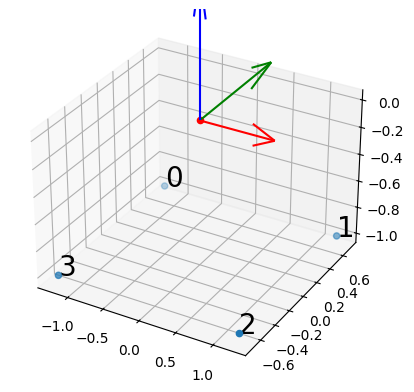

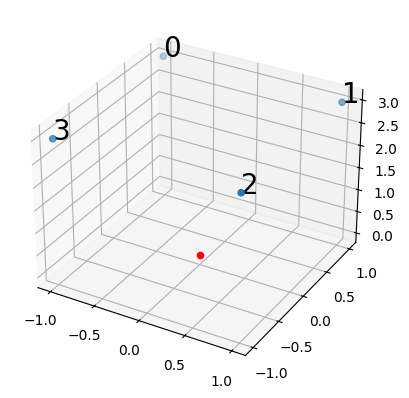

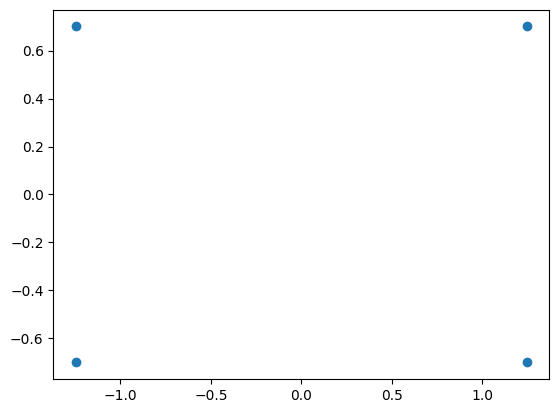

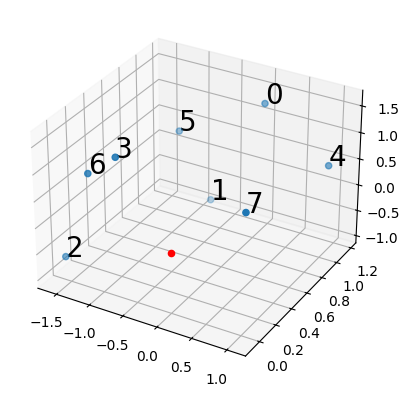

In [11]:
frustum_data_path_1 = './adjustdata/0.dat'
frustum_data_path_2 = './adjustdata/1.dat'

frustum1 = ViewFrustum(frustum_data_path_1)
frustum2 = ViewFrustum(frustum_data_path_2)

frustum1.CalcViewMat()
frustum1.CalcProjectionMat()

# print(frustum1.view_matrix)
# print()
print(frustum1.projection_matrix)
print()


frustum1.CalcFrustumCorners()
frustum2.CalcFrustumCorners()

print(frustum1.near_corners)
# frustum1.near_corners
# frustum1.far_corners


frustum1_conners_on_plane = np.full((4, 4), dtype = np.float64, fill_value=0.0)
frustum1_conners_in_camera_space = np.full((4, 4), dtype = np.float64, fill_value=0.0)
frustum2_conners_on_plane = np.full((4, 4), dtype = np.float64, fill_value=0.0)
for i in range(4):
    # print(i)
    frustum1_conners_in_camera_space[i] = TransformPointToCameraSpace(frustum1.near_corners[i], frustum1)
    frustum1_conners_on_plane[i] = ProjectPointToFrustumPlane(frustum1.near_corners[i], frustum1)
    # frustum2_conners_on_plane[i] = ProjectPointToFrustumPlane(frustum2.far_corners[i], frustum1)
    # frustum1_conners_on_plane[i+4] = ProjectPointToFrustumPlane(frustum1.far_corners[i], frustum1)
    # frustum2_conners_on_plane[i+4] = ProjectPointToFrustumPlane(frustum2.far_corners[i], frustum1)

print(frustum1_conners_in_camera_space)
print(frustum1_conners_on_plane)
DrawPointsIn3DWithCentroidAndAxises(frustum1_conners_in_camera_space)
DrawPointsIn3DWithCentroid(frustum1_conners_on_plane)
DrawPointsOnPlane(frustum1_conners_in_camera_space[:, 0:2])
# print(are_points_in_same_plane(frustum1_conners_in_camera_space[:,0:3]))

tmp = np.append(frustum1.near_corners, frustum2.near_corners, axis=0)
# tmp1 = np.append(frustum1.near_corners, [frustum1.look_at], axis=0)
# tmp2 = np.append(frustum2.near_corners, [frustum2.look_at], axis=0)
DrawPointsIn3DWithCentroid(tmp)
# DrawPointsIn3DWithCentroid(tmp1)
# DrawPointsIn3DWithCentroid(tmp2)

# print(are_points_in_same_plane(tmp1))
# print(are_points_in_same_plane(tmp2))

# DrawPointsIn3DWithCentroid(frustum1.near_corners)
# DrawPointsIn3DWithCentroid(frustum2.near_corners)
# DrawPointsIn3DWithCentroid(frustum1.far_corners)
# DrawPointsIn3DWithCentroid(frustum2.far_corners)
# Define parameters for a new frustum

[0.03004816 0.62583971 0.77937267] [0.03004816 0.62583971 0.77937267]


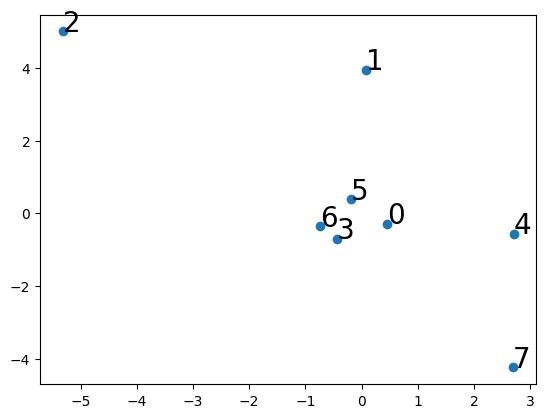

In [12]:
mid_point = (frustum1.look_at + frustum2.look_at) / 2
mid_point = Normalize(mid_point)
centroid, x_axis, y_axis, normal = Build2DCoordinateSysFromOnePointAndNormal(mid_point, mid_point)


tmp1, status, msgs = FindIntersectionsBetweenPlaneAndFrustum(frustum1, normal, centroid)
tmp2, status, msgs = FindIntersectionsBetweenPlaneAndFrustum(frustum2, normal, centroid)

print(Normalize(tmp1[0]), Normalize(frustum1.near_corners[0]))

intersections = np.append(tmp1, tmp2, axis=0)
intersections = TransformPointsTo2DCoordinateSys(intersections, centroid, x_axis, y_axis)

DrawPointsOnPlaneWithSeries(intersections)

[[ 2.68862396 -4.24324737]
 [ 2.70608492 -0.56385184]
 [ 0.08104905  3.96212963]
 [-5.32158026  5.01026547]
 [-0.74374912 -0.35917002]]


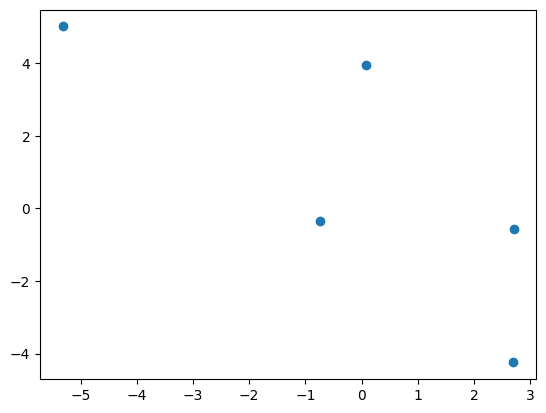

In [13]:
# Define parameters for a new frustum
aspect = 1920.0 / 1080.0
mid_point_in_2D = TransformPointsTo2DCoordinateSys(mid_point, centroid, x_axis, y_axis)
# print(mid_point)
# plot_convex_hull(tmp)
hull = ConvexHull(intersections)
hull_points = intersections[hull.vertices]
print(hull_points)
DrawPointsOnPlane(hull_points)

[31416, 3.1416000000022053]
7.010247348912559 2.068431437040996 [-0.44800482  0.58531587  0.67579361] [-0.50432809  0.86351212]


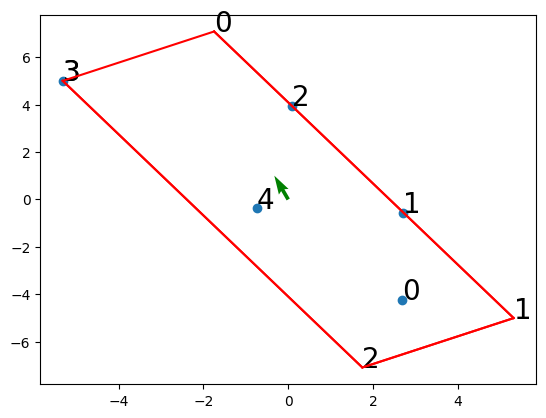

[[-1.74934903  7.09660161]
 [ 5.32158026 -5.01026547]
 [ 1.74934903 -7.09660161]
 [-5.32158026  5.01026547]]
[[ 2.68862396 -4.24324737]
 [ 2.70608492 -0.56385184]
 [ 0.08104905  3.96212963]
 [-5.32158026  5.01026547]
 [-0.74374912 -0.35917002]]


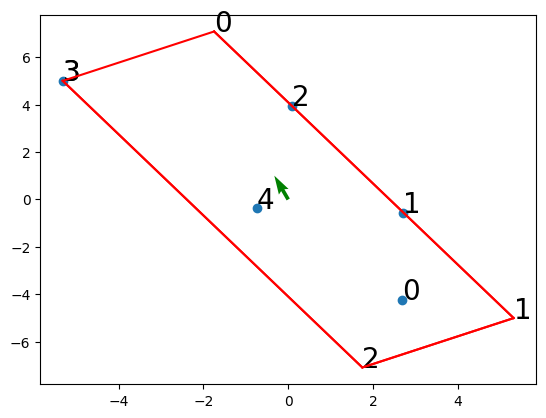

[[-1.74934903  7.09660161]
 [ 5.32158026 -5.01026547]
 [ 1.74934903 -7.09660161]
 [-5.32158026  5.01026547]]
[[ 2.68862396 -4.24324737]
 [ 2.70608492 -0.56385184]
 [ 0.08104905  3.96212963]
 [-5.32158026  5.01026547]
 [-0.74374912 -0.35917002]]


In [14]:
best_width, best_height, best_wide_edge_direction, iter_info = Find_Best_Circumscribed_Rectangle_For_A_Convex_Hull(mid_point_in_2D, hull_points, aspect)
print(iter_info)
print(best_width, best_height, mid_point, best_wide_edge_direction) # The best width and height of the screen that covers the hull
DrawCorveringSolution(mid_point_in_2D, best_width, best_height, best_wide_edge_direction, hull_points)
# Calculate the four corners of the rectangle that covers the hull
screen_corners = np.full((4, 2), dtype = np.float64, fill_value=0.0)
screen_corners[0] = mid_point_in_2D + best_width * best_wide_edge_direction + best_height * np.array([best_wide_edge_direction[1], -best_wide_edge_direction[0]])
screen_corners[1] = mid_point_in_2D - best_width * best_wide_edge_direction + best_height * np.array([best_wide_edge_direction[1], -best_wide_edge_direction[0]])
screen_corners[2] = mid_point_in_2D - best_width * best_wide_edge_direction - best_height * np.array([best_wide_edge_direction[1], -best_wide_edge_direction[0]])
screen_corners[3] = mid_point_in_2D + best_width * best_wide_edge_direction - best_height * np.array([best_wide_edge_direction[1], -best_wide_edge_direction[0]])
# Draw the screen and the hull
fig = plt.figure()
ax = fig.add_subplot(111)
ax.scatter(hull_points[:,0], hull_points[:,1])
# Print the hull points's index
for i in range(len(hull_points)):
    ax.text(hull_points[i,0], hull_points[i,1], '%s' % (str(i)), size=20, zorder=1, color='k')
ax.plot(screen_corners[:,0], screen_corners[:,1], c='r')
ax.plot(screen_corners[[0,1],0], screen_corners[[0,1],1], c='r')
ax.plot(screen_corners[[1,2],0], screen_corners[[1,2],1], c='r')
ax.plot(screen_corners[[2,3],0], screen_corners[[2,3],1], c='r')
ax.plot(screen_corners[[3,0],0], screen_corners[[3,0],1], c='r')
# Draw the corners of the screen with index
for i in range(len(screen_corners)):
    ax.text(screen_corners[i,0], screen_corners[i,1], '%s' % (str(i)), size=20, zorder=1, color='k')

# Also draw the direction of the wide edge
ax.quiver(mid_point_in_2D[0], mid_point_in_2D[1], best_wide_edge_direction[0], best_wide_edge_direction[1], color='g')
plt.show()

print(screen_corners)
print(hull_points)

7.010247348912559 2.068431437040996 [-0.44800482  0.58531587  0.67579361] [-0.75516755  0.15686418 -0.63648692]


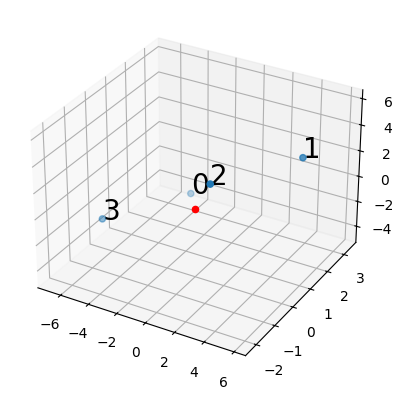

[-0.47855371 -0.79548662  0.37173564]


In [15]:
screen_corners_in_3D = TransformPointsFrom2DCoordinateSys(screen_corners, centroid, x_axis, y_axis)

best_wide_edge_direction_in_3D = TransformVectorFrom2DCoordinateSys(best_wide_edge_direction, x_axis, y_axis)
print(best_width, best_height, mid_point, best_wide_edge_direction_in_3D)
DrawPointsIn3DWithCentroid(screen_corners_in_3D)

# tmp = np.append(screen_corners_in_3D, [frustum1.near_corners[2]], axis=0)
# # tmp = np.append(tmp, frustum2.near_corners, axis=0)
# DrawPointsIn3DWithCentroid(tmp)

# tmp_conner_of_frustum1 = TransformPointsTo2DCoordinateSys(frustum1.near_corners, centroid, x_axis, y_axis)
# print(tmp_conner_of_frustum1)
# print(screen_corners)
# print(Normalize(screen_corners_in_3D[3]), Normalize(frustum1.near_corners[2]))

cover_frustum = FormFrustumWithScreenParameters(np.array([0, 0, 0], dtype=np.float64), mid_point, best_height, best_width, best_wide_edge_direction_in_3D)
print(cover_frustum.up)

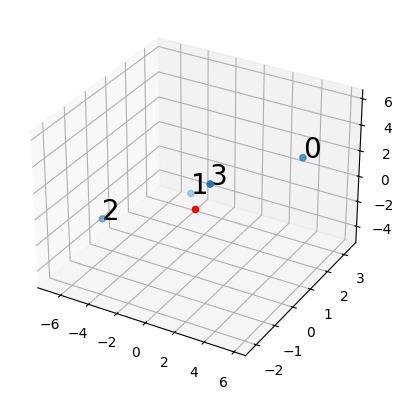

[0. 0. 0.]
[-0.44800482  0.58531587  0.67579361]
[ 0.47855371  0.79548662 -0.37173564]
[1.42910393 1.42910393 1.12046957 1.12046957]
3.389161092494853


In [16]:
# Check if the new frustum's up vector is in an acute angle with the covered frustums' up vector
# If not, flip the up vector
if np.dot(cover_frustum.up, frustum1.up) < 0:
    cover_frustum.up = -cover_frustum.up

cover_frustum.CalcViewMat()
cover_frustum.CalcProjectionMat()
cover_frustum.CalcFrustumCorners()
DrawPointsIn3DWithCentroid(cover_frustum.near_corners)
print(cover_frustum.pos)
print(cover_frustum.look_at)
print(cover_frustum.up)
print(cover_frustum.vfov)
print(cover_frustum.aspect)

cover_frustum.Save_To_File('./CoveringFrustums/cover_0_1.dat')

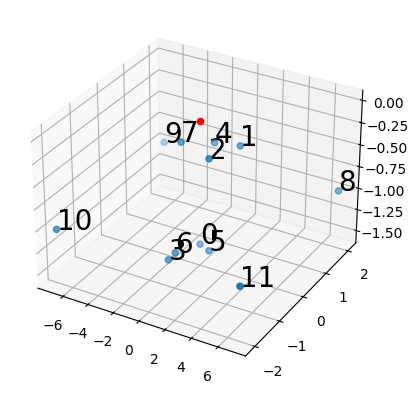

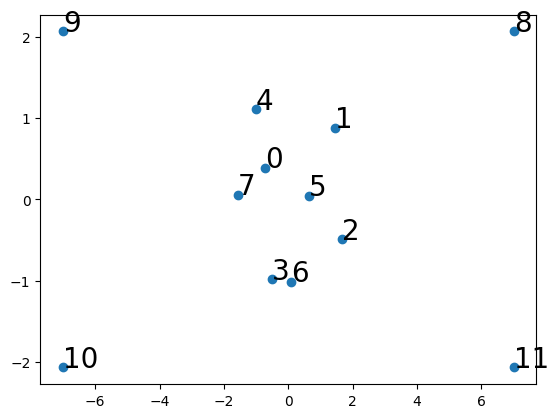

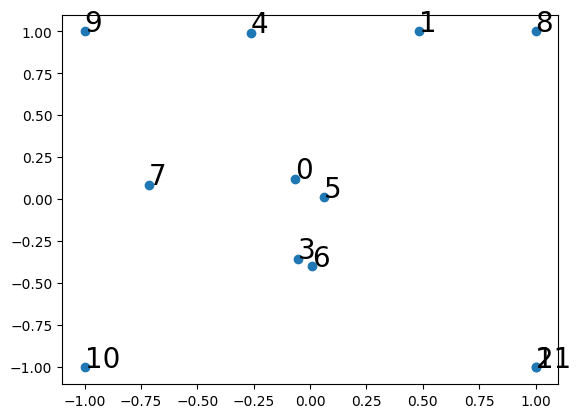

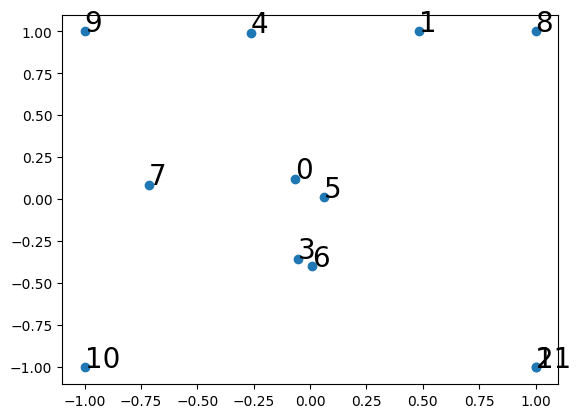

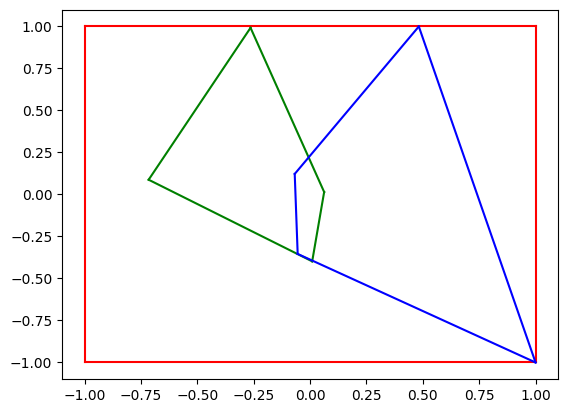

In [17]:
# Transform the covered frustums' corners to the new frustum's camera space
frustum_conners_in_camera_space = np.full((8, 4), dtype = np.float64, fill_value=0.0)
# frustum2_conners_in_camera_space = np.full((4, 4), dtype = np.float64, fill_value=0.0)
for i in range(4):
    frustum_conners_in_camera_space[i] = TransformPointToCameraSpace(frustum1.near_corners[i], cover_frustum)
    frustum_conners_in_camera_space[i+4] = TransformPointToCameraSpace(frustum2.near_corners[i], cover_frustum)
    # frustum2_conners_in_camera_space[i] = TransformPointToCameraSpace(frustum2.near_corners[i], cover_frustum)
    # frustum1_conners_on_plane[i+4] = ProjectPointToFrustumPlane(frustum1.far_corners[i], frustum1)
    # frustum2_conners_on_plane[i+4] = ProjectPointToFrustumPlane(frustum2.far_corners[i], frustum1)
# Transform the covering frustum's corners to the its camera space
screen_corners_in_camera_space = np.full((4, 4), dtype = np.float64, fill_value=0.0)
for i in range(4):
    screen_corners_in_camera_space[i] = TransformPointToCameraSpace(screen_corners_in_3D[i], cover_frustum)

tmp = np.append(frustum_conners_in_camera_space, screen_corners_in_camera_space, axis=0)
DrawPointsIn3DWithCentroid(tmp)
DrawPointsOnPlaneWithSeries(tmp[:,0:2])

# Transform the covered frustums' near corners to the new frustum's clip space
frustum_conners_in_clip_space = np.full((8, 4), dtype = np.float64, fill_value=0.0)
for i in range(4):
    frustum_conners_in_clip_space[i] = ProjectPointToFrustumPlane(frustum1.near_corners[i], cover_frustum)
    frustum_conners_in_clip_space[i+4] = ProjectPointToFrustumPlane(frustum2.near_corners[i], cover_frustum)

# Transform the covering frustum's corners to the its clip space
screen_corners_in_clip_space = np.full((4, 4), dtype = np.float64, fill_value=0.0)
for i in range(4):
    screen_corners_in_clip_space[i] = ProjectPointToFrustumPlane(screen_corners_in_3D[i], cover_frustum)

tmp = np.append(frustum_conners_in_clip_space, screen_corners_in_clip_space, axis=0)
DrawPointsOnPlaneWithSeries(tmp)

# Transform the covered frustums' far corners to the new frustum's clip space
frustum_far_conners_in_clip_space = np.full((8, 4), dtype = np.float64, fill_value=0.0)
for i in range(4):
    frustum_far_conners_in_clip_space[i] = ProjectPointToFrustumPlane(frustum1.far_corners[i], cover_frustum)
    frustum_far_conners_in_clip_space[i+4] = ProjectPointToFrustumPlane(frustum2.far_corners[i], cover_frustum)

tmp = np.append(frustum_far_conners_in_clip_space, screen_corners_in_clip_space, axis=0)
DrawPointsOnPlaneWithSeries(tmp)

# Draw three Screens as Quads
screen_quads = np.full((3, 4, 4), dtype = np.float64, fill_value=0.0)
screen_quads[2] = frustum_conners_in_clip_space[0:4]
screen_quads[1] = frustum_conners_in_clip_space[4:8]
screen_quads[0] = screen_corners_in_clip_space
DrawQuadrilateralsOnPlane(screen_quads)



In [18]:
def CalcAreaOfConvexPolygons(points):
    # Calculate the area of the convex polygon
    area = 0.0
    for i in range(len(points) - 1):
        area += points[i][0] * points[i+1][1] - points[i+1][0] * points[i][1]
    area += points[-1][0] * points[0][1] - points[0][0] * points[-1][1]
    area = abs(area) / 2
    return area


def SphereCoordToCartesianCoord(r, theta, phi):
    x = r * np.sin(theta) * np.cos(phi)
    y = r * np.sin(theta) * np.sin(phi)
    z = r * np.cos(theta)
    return np.array([x, y, z])


def CartesianCoordToSphereCoord(x, y, z):
    r = np.linalg.norm([x, y, z])
    theta = np.arccos(z / r)
    phi = np.arctan2(y, x)
    return r, theta, phi

In [19]:
# # Try 'every' possible direction to find the best frustum
# # Use sphere coordinates to represent the direction
# # Use mid_point as the initial direction
# mid_point = (frustum1.look_at + frustum2.look_at) / 2
# r, theta, phi = CartesianCoordToSphereCoord(mid_point[0], mid_point[1], mid_point[2])
# # print(r, theta, phi)
# init_direction = np.array([theta, phi], dtype=np.float64) # Sphere coordinates: (theta, phi)
# # begin_direction = np.array([theta - 0.5, phi - 0.5], dtype=np.float64) # Sphere coordinates: (theta, phi)
# direction = np.array([theta - 0.5, phi - 0.5], dtype=np.float64) # Sphere coordinates: (theta, phi)
# # direction = init_direction
# direction_step_theta = 0.02
# direction_step_phi = 0.02
# best_area = 0.0
# best_frustum_area = None
# best_fov = np.pi
# best_frustum_fov = None
# iter_cnt = 0
# # Try directions that satisfy the following conditions:
# # theta: [0, pi], phi: [0, 2*pi]
# while  direction[0] <= init_direction[0] + 0.5: #direction[0] >= init_direction[0] - 0.5 and
#     while direction[1] <= init_direction[1] + 0.5:
# # while True:
# #     while True:
#         iter_cnt += 1
#         try: # Catch any warnings or errors, and move to the next direction
#             # Calculate the direction vector
#             direction_vector = SphereCoordToCartesianCoord(1.0, direction[0], direction[1])
#             # Calculate the frustum plane's coordinate system
#             centroid, x_axis, y_axis, normal = Build2DCoordinateSysFromOnePointAndNormal(direction_vector, direction_vector)
#             # Find the intersections between the frustums and the plane
#             tmp1, status, msgs = FindIntersectionsBetweenPlaneAndFrustum(frustum1, normal, centroid)
#             # Check if the intersections are valid
#             if not status:
#                 direction[1] += direction_step_phi
#                 continue
#             tmp2, status, msgs = FindIntersectionsBetweenPlaneAndFrustum(frustum2, normal, centroid)
#             # Check if the intersections are valid
#             if not status:
#                 direction[1] += direction_step_phi
#                 continue
#             # Calculate the intersections in 2D coordinate system
#             intersections = np.append(tmp1, tmp2, axis=0)
#             intersections = TransformPointsTo2DCoordinateSys(intersections, centroid, x_axis, y_axis)
#             # Calculate the convex hull
#             hull = ConvexHull(intersections)
#             hull_points = intersections[hull.vertices]
#             # Calculate the look at point in 2D coordinate system
#             mid_point_in_2D = TransformPointsTo2DCoordinateSys(direction_vector, centroid, x_axis, y_axis)
#             # Find the best circumscribed rectangle
#             best_width, best_height, best_wide_edge_direction, iter_info = Find_Best_Circumscribed_Rectangle_For_A_Convex_Hull(mid_point_in_2D, hull_points, aspect)

#             # DrawCorveringSolution(mid_point_in_2D, best_width, best_height, best_wide_edge_direction, hull_points)
#             # Form the frustum
#             best_wide_edge_direction_in_3D = TransformVectorFrom2DCoordinateSys(best_wide_edge_direction, x_axis, y_axis)
#             cover_frustum = FormFrustumWithScreenParameters(np.array([0, 0, 0], dtype=np.float64), 
#                                                             direction_vector, best_height, best_width, best_wide_edge_direction_in_3D)
#             # Check if the new frustum's up vector is in an acute angle with the covered frustums' up vector
#             # If not, flip the up vector
#             if np.dot(cover_frustum.up, frustum1.up) < 0:
#                 cover_frustum.up = -cover_frustum.up
#             cover_frustum.CalcViewMat()
#             cover_frustum.CalcProjectionMat()
#             cover_frustum.CalcFrustumCorners()
#             # Transform the covered frustums' corners to the new frustum's clip space
#             frustum_conners_in_clip_space = np.full((8, 4), dtype = np.float64, fill_value=0.0)
#             for i in range(4):
#                 frustum_conners_in_clip_space[i] = ProjectPointToFrustumPlane(frustum1.near_corners[i], cover_frustum)
#                 frustum_conners_in_clip_space[i+4] = ProjectPointToFrustumPlane(frustum2.near_corners[i], cover_frustum)
#             # Transform the covering frustum's corners to the its clip space
#             screen_corners_in_clip_space = np.full((4, 4), dtype = np.float64, fill_value=0.0)
#             for i in range(4):
#                 screen_corners_in_clip_space[i] = ProjectPointToFrustumPlane(screen_corners_in_3D[i], cover_frustum)
#             # Remove Z axis in the clip space
#             frustum_conners_in_clip_space = frustum_conners_in_clip_space[:, 0:2]
#             screen_corners_in_clip_space = screen_corners_in_clip_space[:, 0:2]

#             # Calculate the area of the covered frustums' corners' convex hull
#             hull_point_in_clip_space = frustum_conners_in_clip_space[ConvexHull(frustum_conners_in_clip_space).vertices]
#             area = CalcAreaOfConvexPolygons(hull_point_in_clip_space)

#             # Record the best frustum depending on the area: the bigger, the better
#             if area > best_area:
#                 best_area = area
#                 best_frustum_area = cover_frustum

#             # Record the best frustum depending on the fov: the smaller, the better
#             if cover_frustum.vfov[0] < best_fov:
#                 best_fov = cover_frustum.vfov[0]
#                 best_frustum_fov = cover_frustum
#         # Print the exception message and move to the next direction
#         except Exception as e: 
#             print(e)
#             pass
        
#         # Move to the next direction
#         direction[1] += direction_step_phi
#         # break
#     direction[0] += direction_step_theta
#     direction[1] = theta - 0.5
#     # break
# print(iter_cnt)

In [20]:
# # Transform the covered frustums' corners to the new frustum's clip space
# frustum_conners_in_clip_space = np.full((8, 4), dtype = np.float64, fill_value=0.0)
# for i in range(4):
#     frustum_conners_in_clip_space[i] = ProjectPointToFrustumPlane(frustum1.near_corners[i], best_frustum_fov)
#     frustum_conners_in_clip_space[i+4] = ProjectPointToFrustumPlane(frustum2.near_corners[i], best_frustum_fov)

# # Transform the covering frustum's corners to the its clip space
# screen_corners_in_clip_space = np.full((4, 4), dtype = np.float64, fill_value=0.0)
# for i in range(4):
#     screen_corners_in_clip_space[i] = ProjectPointToFrustumPlane(best_frustum_fov.near_corners[i], best_frustum_fov)

# tmp = np.append(frustum_conners_in_clip_space, screen_corners_in_clip_space, axis=0)
# DrawPointsOnPlaneWithSeries(tmp)

In [21]:
# # Calc the covered frustums' corners' intersection in the covering frustum's near plane
# # Form the frustum near plane coordinate system
# centroid, x_axis, y_axis, normal = Build2DCoordinateSysFromOnePointAndNormal(best_frustum_fov.look_at, best_frustum_fov.look_at)
# tmp1, status, msgs = FindIntersectionsBetweenPlaneAndFrustum(frustum1, normal, centroid)
# tmp2, status, msgs = FindIntersectionsBetweenPlaneAndFrustum(frustum2, normal, centroid)
# tmp3, status, msgs = FindIntersectionsBetweenPlaneAndFrustum(best_frustum_fov, normal, centroid)
# intersections = np.append(tmp1, tmp2, axis=0)
# intersections = np.append(intersections, tmp3, axis=0)
# intersections = TransformPointsTo2DCoordinateSys(intersections, centroid, x_axis, y_axis)

# DrawPointsOnPlaneWithSeries(intersections)

In [22]:
# best_frustum_area.Save_To_File("./CoveringFrustums/cover_0_1_biggest_area.dat")
# best_frustum_fov.Save_To_File("./CoveringFrustums/cover_0_1_smallest_fov.dat")